In [1]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime
import statistics
from statistics import mode
from numpy import array

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Masking,Dropout,Embedding
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#input path to data:
with open('C:\\Users\\...', 'r') as file:
        data = pd.read_csv(file)
        data.columns = ((data.columns.str).replace(" ","_"))

data['event_time:timestamp'] = pd.to_datetime(data['event_time:timestamp'].astype(str), format='%d-%m-%Y %H:%M:%S.%f')
data_sorted = data.sort_values(by=['event_time:timestamp']).reset_index(drop=True)
data_sorted

,eventID_,case_concept:name,case_REG_DATE,case_AMOUNT_REQ,event_concept:name,event_lifecycle:transition,event_time:timestamp
0,44964012621824,206324,2012-02-03T17:17:11.047+01:00,2500,A_SUBMITTED,COMPLETE,2012-02-03 17:17:11.047
1,44964012621825,206324,2012-02-03T17:17:11.047+01:00,2500,A_PARTLYSUBMITTED,COMPLETE,2012-02-03 17:17:11.323
2,44964012621826,206324,2012-02-03T17:17:11.047+01:00,2500,A_DECLINED,COMPLETE,2012-02-03 17:17:42.964
3,44968307589120,206327,2012-02-03T17:23:41.949+01:00,6000,A_SUBMITTED,COMPLETE,2012-02-03 17:23:41.949
4,44968307589121,206327,2012-02-03T17:23:41.949+01:00,6000,A_PARTLYSUBMITTED,COMPLETE,2012-02-03 17:23:42.504
...,...,...,...,...,...,...,...
47818,54666343743523,213276,2012-02-27T14:12:41.868+01:00,15000,W_Nabellen incomplete dossiers,START,2012-03-14 15:59:28.309
47819,54666343743524,213276,2012-02-27T14:12:41.868+01:00,15000,W_Nabellen incomplete dossiers,COMPLETE,2012-03-14 16:00:09.680
47820,49495203119136,209595,2012-02-15T10:10:36.503+01:00,13000,W_Nabellen offertes,START,2012-03-14 16:02:03.883
47821,52342766436386,211624,2012-02-21T23:38:40.044+01:00,35000,W_Nabellen incomplete dossiers,START,2012-03-14 16:04:46.192


In [3]:
#Data needed for event prediction
data_filtered_event = data_sorted[['eventID_', 'case_concept:name', 'event_concept:name']]
data_filtered_event['next_event'] = data_filtered_event['event_concept:name'].shift(-1)
data_filtered_event['next_event'].iloc[-1:] = data_filtered_event['event_concept:name'].iloc[-1:] # Might give issues
data_filtered_event

<ipython-input-3-4f9ab08c81ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered_event['next_event'] = data_filtered_event['event_concept:name'].shift(-1)
C:\User Data\Programs\Python\Python3.8.3-64\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-3-4f9ab08c81ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

,eventID_,case_concept:name,event_concept:name,next_event
0,44964012621824,206324,A_SUBMITTED,A_PARTLYSUBMITTED
1,44964012621825,206324,A_PARTLYSUBMITTED,A_DECLINED
2,44964012621826,206324,A_DECLINED,A_SUBMITTED
3,44968307589120,206327,A_SUBMITTED,A_PARTLYSUBMITTED
4,44968307589121,206327,A_PARTLYSUBMITTED,A_PREACCEPTED
...,...,...,...,...
47818,54666343743523,213276,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers
47819,54666343743524,213276,W_Nabellen incomplete dossiers,W_Nabellen offertes
47820,49495203119136,209595,W_Nabellen offertes,W_Nabellen incomplete dossiers
47821,52342766436386,211624,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers


In [17]:
#replace cases with numbers
event_name = data_filtered_event['event_concept:name'].unique()
event_name_dict = dict(zip(event_name, range(len(event_name))))
data_filtered_event['event_concept:name'].replace(event_name_dict, inplace=True)
data_filtered_event['next_event'].replace(event_name_dict, inplace=True)
data_filtered_event

C:\User Data\Programs\Python\Python3.8.3-64\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


(             eventID_  case_concept:name  event_concept:name  next_event  \
 0      44964012621824             206324                   0           1   
 1      44964012621825             206324                   1           2   
 2      44964012621826             206324                   2           0   
 3      44968307589120             206327                   0           1   
 4      44968307589121             206327                   1           3   
 ...               ...                ...                 ...         ...   
 47818  54666343743523             213276                  17          17   
 47819  54666343743524             213276                  17          11   
 47820  49495203119136             209595                  11          17   
 47821  52342766436386             211624                  17          17   
 47822  52342766436387             211624                  17          17   
 
                  LSTM_predict  
 0         W_Nabellen offertes  
 1      

In [5]:
all_traces = data_filtered_event.groupby('case_concept:name')['event_concept:name'].apply(list).tolist()
all_traces_val = data_filtered_event.groupby('case_concept:name')['next_event'].apply(list).tolist()

In [6]:
traces_3d = list()
for i in all_traces:
    for j in range(1, len(i)):
        if j == 1:
            trace_2d = [0, 0]
            traces_3d.append(trace_2d)
        else:
            trace_2d = i[j-2:j]
            traces_3d.append(trace_2d)

traces_3d_val = list()
for i in all_traces_val:
    for j in range(0, len(i)-1):
        trace_2d = i[j+1]
        traces_3d_val.append(trace_2d)


In [7]:
traces_padded = pad_sequences(traces_3d, maxlen = 2, padding = 'pre')
traces_array = array(traces_padded)
traces_val_array = array(traces_3d_val)

In [8]:
all_traces, all_traces_valid, all_traces_val, all_traces_val_valid = train_test_split(traces_array, traces_val_array, test_size = 0.2, random_state = 21)
all_traces
        


array([[11, 11],
       [ 4,  6],
       [ 4,  4],
       ...,
       [ 4,  4],
       [ 4,  4],
       [ 4,  4]])

In [9]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(len(event_name), 50, input_length = 2))
model_LSTM.add(LSTM(50))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(len(event_name), activation = 'softmax'))

model_LSTM.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy','mse'])

history = model_LSTM.fit(all_traces, all_traces_val, epochs = 5, verbose = 2, batch_size = 20, validation_data = (all_traces_valid, all_traces_val_valid))

Epoch 1/5
1809/1809 - 16s - loss: 1.9648 - accuracy: 0.4235 - mse: 104.7481 - val_loss: 1.8089 - val_accuracy: 0.4557 - val_mse: 103.6868
Epoch 2/5
1809/1809 - 13s - loss: 1.8217 - accuracy: 0.4518 - mse: 104.7502 - val_loss: 1.7813 - val_accuracy: 0.4592 - val_mse: 103.6860
Epoch 3/5
1809/1809 - 13s - loss: 1.8070 - accuracy: 0.4552 - mse: 104.7505 - val_loss: 1.7769 - val_accuracy: 0.4617 - val_mse: 103.6862
Epoch 4/5
1809/1809 - 13s - loss: 1.7954 - accuracy: 0.4571 - mse: 104.7505 - val_loss: 1.7657 - val_accuracy: 0.4629 - val_mse: 103.6864
Epoch 5/5
1809/1809 - 12s - loss: 1.7884 - accuracy: 0.4564 - mse: 104.7506 - val_loss: 1.7625 - val_accuracy: 0.4659 - val_mse: 103.6856


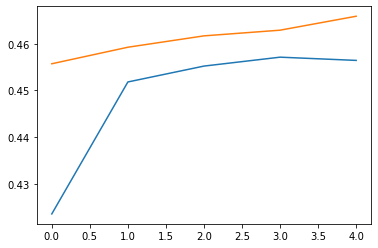

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [11]:
#Results for both the train and test
traces_result = np.argmax(model_LSTM.predict(all_traces), axis=1)
traces_valid_result = np.argmax(model_LSTM.predict(all_traces_valid), axis=1)

#Different way of trying the same: Also works when changing some other lines below but also has NAN values at the bottom
#event_result = pd.DataFrame({'expected_event': all_traces_val, 'predicted_event': traces_result})
#event_valid_result = pd.DataFrame({'expected_event': all_traces_val_valid, 'predicted_event': traces_valid_result})
#event_result_temp = pd.DataFrame()
#event_result_temp['predicted_event'] = event_result['predicted_event']
#event_result_temp['predicted_event_val'] = event_valid_result['predicted_event']
#event_result_temp['predicted_event'].append(event_result_temp['predicted_event_val'], ignore_index=True)

#Combining results and adding them to the original dataset
traces_combined_result = np.concatenate((traces_result , traces_valid_result))
traces_result_temp = pd.DataFrame({'predicted_event': traces_result})
data_filtered_event['LSTM_predict'] = traces_result_temp['predicted_event']

#Reverse dictionary to get the original events back instead of numbers
inv_event_name_dict = {v: k for k, v in event_name_dict.items()}
data_filtered_event['LSTM_predict'].replace(inv_event_name_dict, inplace=True)
data_filtered_event['event_concept:name'].replace(inv_event_name_dict, inplace=True)
data_filtered_event['next_event'].replace(inv_event_name_dict, inplace=True)

data_filtered_event

<ipython-input-11-b914e23c6705>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered_event['LSTM_predict'] = traces_result_temp['predicted_event']
C:\User Data\Programs\Python\Python3.8.3-64\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,eventID_,case_concept:name,event_concept:name,next_event,LSTM_predict
0,44964012621824,206324,A_SUBMITTED,A_PARTLYSUBMITTED,W_Nabellen offertes
1,44964012621825,206324,A_PARTLYSUBMITTED,A_DECLINED,A_FINALIZED
2,44964012621826,206324,A_DECLINED,A_SUBMITTED,W_Completeren aanvraag
3,44968307589120,206327,A_SUBMITTED,A_PARTLYSUBMITTED,W_Valideren aanvraag
4,44968307589121,206327,A_PARTLYSUBMITTED,A_PREACCEPTED,W_Nabellen offertes
...,...,...,...,...,...
47818,54666343743523,213276,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers,NaN
47819,54666343743524,213276,W_Nabellen incomplete dossiers,W_Nabellen offertes,NaN
47820,49495203119136,209595,W_Nabellen offertes,W_Nabellen incomplete dossiers,NaN
47821,52342766436386,211624,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers,NaN


In [14]:
data_filtered_event.to_csv('event_time_BPI2012_LSTM.csv')